<a href="https://colab.research.google.com/github/VinodKumar9576/test/blob/master/Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://github.com/rahulpatraiitkgp/Finding-Donors-For-CharityML/blob/master/finding_donors.ipynb

**<h1>Getting Started**

* In this project, we'll implement several supervised algorithms to accurately model individuals' income using data collected.
* Then a best algorithm from preliminary results is chosen and further optimize this algorithm to best model the data.
* Goal of this implementation is to construct a model that accurately predicts whether an individual makes more than \$50,000.
* This kind of tasks arise in a non-profit setting, where organizations survive on donations.
* Understanding an individual's income can help a non-profit better understand how large of a donation to request, or whether or not they should reach out to begin with.
* It can be difficult to determine an individual's general income directly from public sources, we infter this value from other publicly availabe features.

**<h1>Exploring the data**

In [1]:
!mkdir ~/.kaggle

!touch ~/.kaggle/kaggle.json

api_key = {'username':'vinodkumar9576', 'key':'af074010bd4c7bb75f9d1fe71f31452d'}

import json

with open('/root/.kaggle/kaggle.json','w') as file:
  json.dump(api_key, file)

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d vinodkumar9576/finding-donor-for-charity

from zipfile import ZipFile
import pandas as pd

with ZipFile('/content/finding-donor-for-charity.zip','r') as z:
  train_df = pd.read_csv(z.open('census.csv'))

#printing files in donwloaded zip file
print(' ')
print('Files in downloaded zip folder')
for names in ZipFile('/content/finding-donor-for-charity.zip').namelist():
  print(names)

mkdir: cannot create directory ‘/root/.kaggle’: File exists
finding-donor-for-charity.zip: Skipping, found more recently modified local copy (use --force to force download)
 
Files in downloaded zip folder
census.csv
example_submission.csv
test_census.csv


In [2]:
train_df.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45222 entries, 0 to 45221
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              45222 non-null  int64  
 1   workclass        45222 non-null  object 
 2   education_level  45222 non-null  object 
 3   education-num    45222 non-null  float64
 4   marital-status   45222 non-null  object 
 5   occupation       45222 non-null  object 
 6   relationship     45222 non-null  object 
 7   race             45222 non-null  object 
 8   sex              45222 non-null  object 
 9   capital-gain     45222 non-null  float64
 10  capital-loss     45222 non-null  float64
 11  hours-per-week   45222 non-null  float64
 12  native-country   45222 non-null  object 
 13  income           45222 non-null  object 
dtypes: float64(4), int64(1), object(9)
memory usage: 4.8+ MB


**<h2>Implementation: Data Exploration**

We'll compute the following:
* Total no. of records, 'n_records'
* No. of individuals making $\gt$ \$50,000/year, 'n_greater_50k'
* No. of individuals making at most \$50,000/year, n_at_most_50k'
* Percentage of individuals making $\gt$ \$50,000/year, 'greater_percent'


In [4]:
n_records = train_df.shape[0]

n_greater_50k = train_df[train_df['income']=='>50K'].shape[0]

n_at_most_50k = train_df[train_df['income']=='<=50K'].shape[0]

greater_percent = (train_df[train_df['income']=='>50K'].shape[0]/n_records)*100

# Print the results
print("Total number of records: {}".format(n_records))
print("Individuals making more than $50,000: {}".format(n_greater_50k))
print("Individuals making at most $50,000: {}".format(n_at_most_50k))
print("Percentage of individuals making more than $50,000: {}%".format(greater_percent))

Total number of records: 45222
Individuals making more than $50,000: 11208
Individuals making at most $50,000: 34014
Percentage of individuals making more than $50,000: 24.78439697492371%


**<h2>Feature set Exploration**

Now we'll see each feature and what type of categorical values it holds:
<br>

**All below are continuous features**
* **age** : continuous
* **capital-gain**: continuous.
* **capital-loss**: continuous.
* **hours-per-week**: continuous.
<br>

**All below are categorical features**
* **workclass**: Private, Self-emp-not-inc, Local-gov, State-gov, Self-emp-inc, Federal-gov, Without-pay.
* **education_level**: HS-grad, Some-college, Bachelors, Masters, Assoc-voc, 11th, Assoc-acdm, 10th, 7th-8th, Prof-school, 9th, 12th, Doctorate, 5th-6th, 1st-4th, Preschool.
* **education-num**: continuous.
* **marital-status**: Married-civ-spouse, Divorced, Never-married, Separated, Widowed, Married-spouse-absent, Married-AF-spouse.
* **occupation**: Tech-support, Craft-repair, Other-service, Sales, Exec-managerial, Prof-specialty, Handlers-cleaners, Machine-op-inspct, Adm-clerical, Farming-fishing, Transport-moving, Priv-house-serv, Protective-serv, Armed-Forces.
* **relationship**: Wife, Own-child, Husband, Not-in-family, Other-relative, Unmarried.
* **race**: Black, White, Asian-Pac-Islander, Amer-Indian-Eskimo, Other.
* **sex**: Female, Male.
* **native-country**: United-States, Cambodia, England, Puerto-Rico, Canada, Germany, Outlying-US(Guam-USVI-etc), India, Japan, Greece, South, China, Cuba, Iran, Honduras, Philippines, Italy, Poland, Jamaica, Vietnam, Mexico, Portugal, Ireland, France, Dominican-Republic, Laos, Ecuador, Taiwan, Haiti, Columbia, Hungary, Guatemala, Nicaragua, Scotland, Thailand, Yugoslavia, El-Salvador, Trinadad&Tobago, Peru, Hong, Holand-Netherlands.

**<h1>Preparing the Data**

**<h3>Checking for missing values**

In [5]:
train_df.isnull().sum().sum()
#train_df.isnull().values.any()

0

**<h3>Transforming Skewed Continous Features**

* A dataset may sometimes contain at least one feature whose most the values lie near a **single value**, but will also have a non-trivial number of vastly **larger** or **smaller** values that that **single number**.
* Algorithms can be sensitive to such distributions of values and can underperform if the range is not properly normalized.
* Plot the distributions of all the features in the given dataset to see if any features are having plots in above said way.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


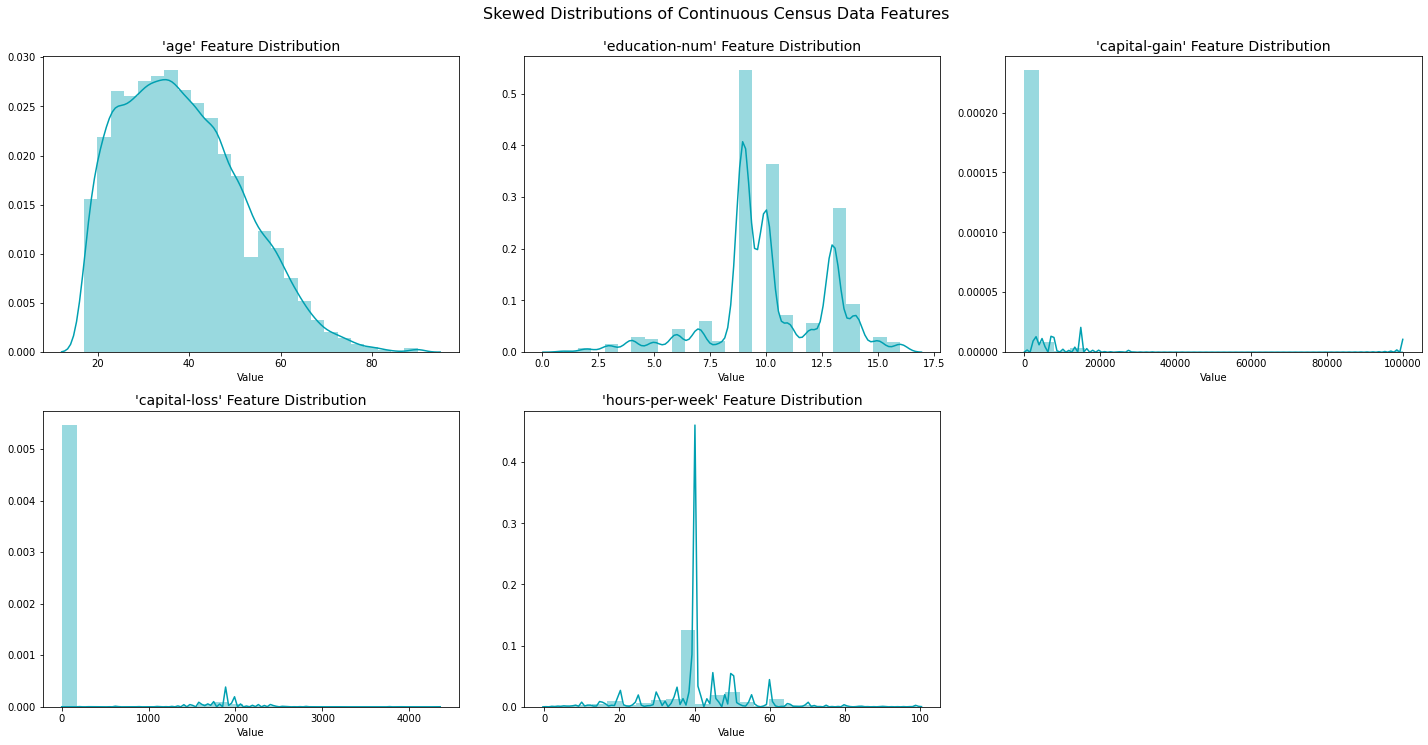

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,10))

for k,feature in enumerate(train_df.select_dtypes(include=['int64','float64']).columns):
  ax = fig.add_subplot(2,3,k+1)
  x=train_df[feature]
  sns.distplot(x, bins = 25, color = '#00a0b1')
  ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
  ax.set_xlabel("Value")
  #ax.set_ylabel("Number of Records")

fig.suptitle("Skewed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
fig.tight_layout()
fig.show()

**Skewness measure**

In [7]:
import numpy as np
from scipy.stats import kurtosis, skew

cg = train_df['capital-gain']
cl = train_df['capital-loss']

#print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(cg) ))
print( 'skewness of Capital-gain distribution (should be 0): {}'.format( skew(cg) ))
print( 'skewness of Capital-loss distribution (should be 0): {}'.format( skew(cl) ))

skewness of Capital-gain distribution (should be 0): 11.788611139067774
skewness of Capital-loss distribution (should be 0): 4.516154347164751


* From above plots of continous data features, found two features fit the conditions: 'capital-gain' and 'capital-loss'.
* For highly-skewed feature distributions, it is common practice to apply a **logarithmic transformation** on the data to make very large and very small values not to negatively affect the performance of a learning algorithm.
* Using the **logarithmic transformation** reduces the range of values caused by outliers.
* If the value of cell is zero in a column, then problem arises as log(0) is undefined. So, we raise the values 0 to small amount.

In [0]:
#log-transformation of skewed features
features_raw = train_df.drop(labels=['income'], axis=1)
income_raw = train_df['income']
skewed = ['capital-gain','capital-loss']
features_log_tr = features_raw.copy()
features_log_tr[skewed] = features_raw[skewed].apply(lambda x: np.log(x+1))

In [16]:
features_log_tr.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,39,State-gov,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,7.684784,0.0,40.0,United-States
1,50,Self-emp-not-inc,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,13.0,United-States
2,38,Private,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,40.0,United-States
3,53,Private,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,40.0,United-States
4,28,Private,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,40.0,Cuba


**Plotting distribution of log transformed features**

In [0]:
#we are making another dataframe that holds skewed and unskewed features
feats_sk_unsk = pd.DataFrame(data=features_raw[skewed].values, columns=['capital-gain-sk','capital-loss-sk'])
feats_sk_unsk[['capital-gain-un','capital-loss-un']] = features_log_tr[skewed]

In [10]:
feats_sk_unsk.head()

,capital-gain-sk,capital-loss-sk,capital-gain-un,capital-loss-un
0,2174.0,0.0,7.684784,0.0
1,0.0,0.0,0.000000,0.0
2,0.0,0.0,0.000000,0.0
3,0.0,0.0,0.000000,0.0
4,0.0,0.0,0.000000,0.0


**Skewness measure after log-tranformation**

In [11]:
import numpy as np
from scipy.stats import kurtosis, skew

cgu = feats_sk_unsk['capital-gain-un']
clu = feats_sk_unsk['capital-loss-un']

#print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(cg) ))
print( 'skewness of Capital-gain distribution (should be 0): {}'.format( skew(cgu) ))
print( 'skewness of Capital-loss distribution (should be 0): {}'.format( skew(clu) ))

skewness of Capital-gain distribution (should be 0): 3.082283677468687
skewness of Capital-loss distribution (should be 0): 4.271053094292741


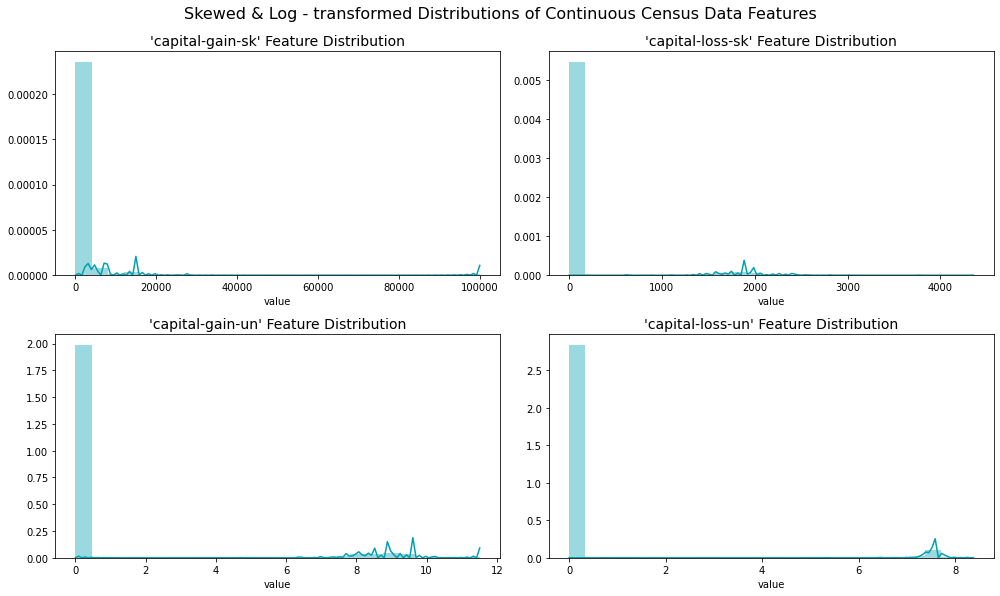

In [14]:
fig = plt.figure(figsize=(14,8))
for k,feature in enumerate(feats_sk_unsk.columns):
  ax = fig.add_subplot(2,2,k+1)
  x = feats_sk_unsk[feature]
  sns.distplot(x, bins = 25, color = '#00a0b1')
  ax.set_title("'%s' Feature Distribution"%(feature), fontsize = 14)
  ax.set_xlabel('value')

fig.suptitle("Skewed & Log - transformed Distributions of Continuous Census Data Features", \
            fontsize = 16, y = 1.03)
fig.tight_layout()
fig.show()

**Kurtosis after log-transformation**

In [12]:
import numpy as np
from scipy.stats import kurtosis, skew

cgu = feats_sk_unsk['capital-gain-un']
clu = feats_sk_unsk['capital-loss-un']

#print( 'excess kurtosis of normal distribution (should be 0): {}'.format( kurtosis(cg) ))
print( 'Kurtosis of Capital-gain distribution (should be 0): {}'.format( kurtosis(cgu) ))
print( 'Kurtosis of Capital-loss distribution (should be 0): {}'.format( kurtosis(clu) ))

Kurtosis of Capital-gain distribution (should be 0): 7.705670616683776
Kurtosis of Capital-loss distribution (should be 0): 16.260832354556662


**<h3>Normalizing Numerical Features**

* In addition to performing transformations on features that are highly skewed, it is often good practice to perform some type of scaling on numerical features.
* Applying **Normalization** doesn't change the shape of each feature's distribution; however normalization ensures that each feature is equally treated when applying supervised learners.
* Note that once scaling is applied, observing the data in its raw form will not have the same original meaning.

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() #default(0, 1)
features_log_minmax_tr = features_log_tr.copy()

#below detects 'int64', 'float64' dtype columns and forms a list
numerical = [feat for feat in features_log_minmax_tr.select_dtypes(include=['int64', 'float64']).columns]

features_log_minmax_tr[numerical] = scaler.fit_transform(features_log_minmax_tr[numerical])

#normalized numerical features
features_log_minmax_tr.head()

,age,workclass,education_level,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,0.301370,State-gov,Bachelors,0.800000,Never-married,Adm-clerical,Not-in-family,White,Male,0.667492,0.0,0.397959,United-States
1,0.452055,Self-emp-not-inc,Bachelors,0.800000,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.000000,0.0,0.122449,United-States
2,0.287671,Private,HS-grad,0.533333,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.000000,0.0,0.397959,United-States
3,0.493151,Private,11th,0.400000,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.000000,0.0,0.397959,United-States
4,0.150685,Private,Bachelors,0.800000,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.000000,0.0,0.397959,Cuba


**<h2>Implementation: Data Preprocessing**

* There are several features in the data set that are non-numerical like 'object' dataype.
* Typically, learning algorithms expect inputs to be numerial which requires that non-numerics needs to be converted.
* One popular way to convert categorical features is by using **one-hot-encoding** scheme.
* One-hot encoding creates a 'dummy' variable for each possible category of each non-numeric feature.
* In our case we need to convert the non-numeric output feature 'income' to numerical values for the learning algorithm to work.
* As there are only two possible categories for this label ('<=50K' and '>50K'), we can aviod using one-hot encoding and simply manually encode these two as '0' and '1' respectively.
  * Use pandas.get_dummies() to perform one-hot-encoding on the other non-numerical features.
  * Convert the target label 'income_raw' to numerical entries.

In [25]:
!pip install swifter

     |████████████████████████████████| 3.6MB 3.8MB/s 
     |████████████████████████████████| 450kB 35.4MB/s 
     |████████████████████████████████| 634kB 18.2MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
  Created wheel for psutil: filename=psutil-5.7.0-cp36-cp36m-linux_x86_64.whl size=272668 sha256=72513e31612a80d56cb162cc1a204b6986882082b5e60417121cbd810bbde4be
  Stored in directory: /root/.cache/pip/wheels/d7/69/b4/3200b95828d1f0ddb3cb5699083717f4fdbd9b4223d0644c57
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=4a980a10652f03d14631a35f478a9dbe19393c232d892501f1a84bbea3c9d346
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36-none-any.whl size=4040 sha256=36af2b6c6db2177b4690bc68262730766d426e2787c78a773c1618f14a3de859
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf18

In [26]:
import swifter
#encoding the other features
features_final = pd.get_dummies(features_log_minmax_tr)

#encoding the output variable
#we use swifter here to apply function faster
income = income_raw.swifter.apply(lambda x: 1 if x == '>50K' else 0)

encoded = list(features_final.columns)
print('{} total features after one-hot encoding.'.format(len(encoded)))
print(' ')

print(encoded)



103 total features after one-hot encoding.
 
['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week', 'workclass_ Federal-gov', 'workclass_ Local-gov', 'workclass_ Private', 'workclass_ Self-emp-inc', 'workclass_ Self-emp-not-inc', 'workclass_ State-gov', 'workclass_ Without-pay', 'education_level_ 10th', 'education_level_ 11th', 'education_level_ 12th', 'education_level_ 1st-4th', 'education_level_ 5th-6th', 'education_level_ 7th-8th', 'education_level_ 9th', 'education_level_ Assoc-acdm', 'education_level_ Assoc-voc', 'education_level_ Bachelors', 'education_level_ Doctorate', 'education_level_ HS-grad', 'education_level_ Masters', 'education_level_ Preschool', 'education_level_ Prof-school', 'education_level_ Some-college', 'marital-status_ Divorced', 'marital-status_ Married-AF-spouse', 'marital-status_ Married-civ-spouse', 'marital-status_ Married-spouse-absent', 'marital-status_ Never-married', 'marital-status_ Separated', 'marital-status_ Widowed', 'occupation

In [29]:
#lets have a look at final features we have at hand
features_final

,age,education-num,capital-gain,capital-loss,hours-per-week,workclass_ Federal-gov,workclass_ Local-gov,workclass_ Private,workclass_ Self-emp-inc,workclass_ Self-emp-not-inc,workclass_ State-gov,workclass_ Without-pay,education_level_ 10th,education_level_ 11th,education_level_ 12th,education_level_ 1st-4th,education_level_ 5th-6th,education_level_ 7th-8th,education_level_ 9th,education_level_ Assoc-acdm,education_level_ Assoc-voc,education_level_ Bachelors,education_level_ Doctorate,education_level_ HS-grad,education_level_ Masters,education_level_ Preschool,education_level_ Prof-school,education_level_ Some-college,marital-status_ Divorced,marital-status_ Married-AF-spouse,marital-status_ Married-civ-spouse,marital-status_ Married-spouse-absent,marital-status_ Never-married,marital-status_ Separated,marital-status_ Widowed,occupation_ Adm-clerical,occupation_ Armed-Forces,occupation_ Craft-repair,occupation_ Exec-managerial,occupation_ Farming-fishing,...,native-country_ Canada,native-country_ China,native-country_ Columbia,native-country_ Cuba,native-country_ Dominican-Republic,native-country_ Ecuador,native-country_ El-Salvador,native-country_ England,native-country_ France,native-country_ Germany,native-country_ Greece,native-country_ Guatemala,native-country_ Haiti,native-country_ Holand-Netherlands,native-country_ Honduras,native-country_ Hong,native-country_ Hungary,native-country_ India,native-country_ Iran,native-country_ Ireland,native-country_ Italy,native-country_ Jamaica,native-country_ Japan,native-country_ Laos,native-country_ Mexico,native-country_ Nicaragua,native-country_ Outlying-US(Guam-USVI-etc),native-country_ Peru,native-country_ Philippines,native-country_ Poland,native-country_ Portugal,native-country_ Puerto-Rico,native-country_ Scotland,native-country_ South,native-country_ Taiwan,native-country_ Thailand,native-country_ Trinadad&Tobago,native-country_ United-States,native-country_ Vietnam,native-country_ Yugoslavia
0,0.301370,0.800000,0.667492,0.0,0.397959,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0.452055,0.800000,0.000000,0.0,0.122449,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,0.287671,0.533333,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0.493151,0.400000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0.150685,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45217,0.219178,0.800000,0.000000,0.0,0.397959,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
45218,0.301370,0.800000,0.000000,0.0,0.357143,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
45219,0.287671,0.800000,0.000000,0.0,0.500000,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
45220,0.369863,0.800000,0.747375,0.0,0.397959,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0

**<h1> Shuffle and Split the Data**

* Now all the categorical features have been converted into numerical features and all the numerical features are normalized.
* As the next step we'll split the data (both features and their labels) into training and test sets.
* 80% of the data will be used for training and 20% for testing.

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(features_final,
                                                    income,
                                                    test_size=0.2,
                                                    random_state=0)

#show count of samples
print('Training set has {} samples.'.format(X_train.shape[0]))
print('Testing set has {} samples.'.format(X_test.shape[0]))

Training set has 36177 samples.
Testing set has 9045 samples.


**<h1>Evaluating Model Performance**

* In this section, we'll investigate four different algorithms, and determine which is best at modeling the data.
* Three of the algorithms will be supervised learners and the fourth will be '*naive predictor*'.

**<h2>Metrics and the Naive Predictor**

* Dudes who gave this problem already know from their research that individuals make more than \$50,000 are most likely to donate to their charity.
* Because of this *CharityML* is 